# Portfolio Task 3: Time series forecasting - ANN

## Introduction:
The value of one pound sterling in US dollars is reported as a time series variable. The US/UK exchange rate data is downloaded from the Federal Reserve Economic Data website: https://fred.stlouisfed.org/series/DEXUSUK (Note, the link will open in a new tab).

The source of data is the Board of Governors of the Federal Reserve System (US). The value of one British pound to the US dollar is decreasing after `July 2014` but with some fluctuations. The data set includes the daily exchange rate from `January 4, 2010` until `August 7, 2020`.

## Questions:

Forecast the exchange rate for `August 8, 2020` using an `artificial neural network`

[1. Analyse data and indicate the number of inputs and outputs and the values for them in a separate file (in Excel or SPSS). Why do you select your inputs and outputs, is there any analysis supporting your choices?](#3_1)

[2. Use the neural network and train a suitable model for your data. Report the tables and diagrams you get as an output from the SPSS and interpret the results in the report. Explain your neural network with details and provide the performance analysis for the method. Is the model you proposed a good model? How do you support your claim? Also provide the table of preferences for the input values and interpret it.](#3_2)

Use plots where necessary to support the data analysis. Also report the one-step-ahead forecast, the exchange rate for `August 8, 2020`.

## Key Findings:
- The changes in the GBP/USD exchange rate show dependence primarily on the most recent rate, but this does not fully capture the complexity of exchange rate movements. Other factors, including economic indicators, market sentiment, and external shocks can be considered to make a more acurrate forecast.

- The ARNN model can accurately predicts the next-day GBP/USD exchange rate when provided with known lag/input values. However, when using predicted values as inputs for longer-term forecasts, the model struggles to accurately capture the exchange rate pattern. 
- For reliable long-term predictions, a more advanced approach is required, one that incorporates additional economic indicators beyond historical rates and utilises a more complex model to effectively capture complex market dynamics.

## The Project Directory:

The Portfolio 3 Project files can be found in the Github Repository: [github.com/lamtong/portfolio3_gbp_usd_arnn](https://github.com/lamtong/portfolio3_gbp_usd_arnn)

## I. Data Pre processing

In [264]:
# import packages
import pandas as pd
import numpy as np  
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import tensorflow as tf
import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import sys
import os
from keras.utils import plot_model
import graphviz
from keras.callbacks import EarlyStopping
from sklearn.inspection import permutation_importance

sys.path.append(os.path.abspath(".."))
from shared_files.custom_plots import plot_props  # Import the customise plot module

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)  # Ignore FutureWarnings
warnings.simplefilter(action="ignore", category=pd.errors.SettingWithCopyWarning) # Ignore SettingWithCopyWarning

In [265]:
# import datasets
df = pd.read_excel('exchange-rate-uk-us-data.xlsx')

# inspect the dataset
df

,FRED Graph Observations,Unnamed: 1
0,Federal Reserve Economic Data,NaN
1,Link: https://fred.stlouisfed.org,NaN
2,Help: https://fred.stlouisfed.org/help-faq,NaN
3,Economic Research Division,NaN
4,Federal Reserve Bank of St. Louis,NaN
...,...,...
2770,2020-08-03 00:00:00,1.3053
2771,2020-08-04 00:00:00,1.3059
2772,2020-08-05 00:00:00,1.3141
2773,2020-08-06 00:00:00,1.3147


In [266]:
# split the set
df_metadata = df.loc[:8]    # the data info
df          = df.loc[10:]   # the main dataset for analysis

# rename column
df = df.rename(columns = {df.columns[0]: 'date', 
                        df.columns[1]: 'DEXUSUK'})

# Casting 'date' to datetime format
df['date'] = pd.to_datetime(df['date'], format='%Y-%m')

In [267]:
# dataset info
df.info()

# Number of NULL in 'DEXUSUK'
no_null = df['DEXUSUK'].isnull().sum()
print(f'\nNumber of missing values in "DEXUSUK": {no_null}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2765 entries, 10 to 2774
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     2765 non-null   datetime64[ns]
 1   DEXUSUK  2655 non-null   object        
dtypes: datetime64[ns](1), object(1)
memory usage: 43.3+ KB

Number of missing values in "DEXUSUK": 110


#### Using Forward Fill (Carries the last valid observation forward) to replace the missing value:


In [268]:
# forward fill
df['DEXUSUK'].fillna(method='ffill', inplace=True)

## II. Portfolio 3 Tasks

<a name="3_1"></a>
### 1. Analyse data and indicate the number of inputs and outputs and the values for them in a separate file: 

Why do you select your inputs and outputs, is there any analysis supporting your choices?

#### The Original Series of GBP/USD Exchange Rate:

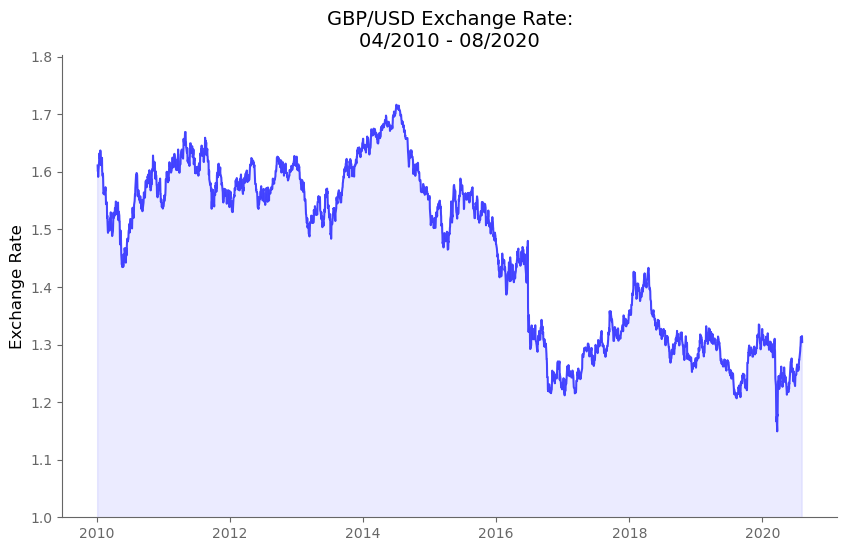

In [ ]:
# Plot the original time series data
plt.figure(figsize=(10, 6))
sns.lineplot(x     =  df['date'],
             y     =  df['DEXUSUK'],
             color = 'blue',
             alpha = 0.7) 
plt.fill_between(df['date'], df['DEXUSUK'], color = 'blue', alpha=.08) 

# Show the plot
plt.ylim(bottom = 1)
plot_props(title          = 'GBP/USD Exchange Rate:\n04/2010 - 08/2020', 
           y_label        = 'Exchange Rate',
           legend         = False)

#### Autocorrelation (ACF) and Partial Autocorrelation (PACF) Plots of the Series:

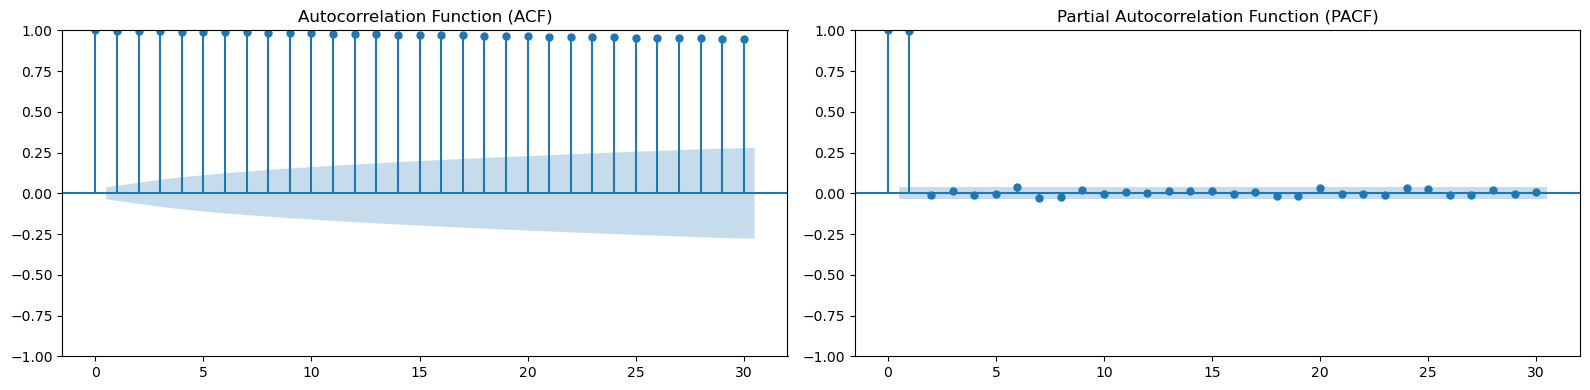

In [270]:
def auto_cor(series):

    # Plot ACF and PACF for the original series
    fig, axes = plt.subplots(1, 2, figsize=(16, 4))

    # ACF plot
    plot_acf(series, lags=30, ax=axes[0])
    axes[0].set_title('Autocorrelation Function (ACF)')

    # PACF plot
    plot_pacf(series, lags=30, ax=axes[1])
    axes[1].set_title('Partial Autocorrelation Function (PACF)')

    plt.tight_layout()
    plt.show()

auto_cor(df['DEXUSUK'])

#### ARNN Model's Inputs and Ouputs:
- **Model Input:** Based on the PACF plot, only the first lag is significant, thus the ARNN model will have `one input`, which is the value of the first lag.
- **Model Output:** The goal is to predict the next day value of GBP/USD exchange rate, then there is `one output` of the model, which is the predicted GBP/USD exchange rate.

#### Export the Training Data file of The Neural Network to *exchange_rate_GBP_USD.csv* file:

In [271]:
# Initiate the Number of Lags as Inputs
lag_num = 1

def add_lags(data, series, num_lags):
    '''This function add the collumns of normalised lags for the ANN Model

    Arguments:
        data -- the data series
        num_lags -- desired number of lags
    '''
    # Add new rows with all columns as NaN, using new date
    for i in range(1, num_lags+1):
        # Compute the next date: add one day to the last date in the index
        new_date = data.index[-1] + 1
        
        # Assign a new row with the new_date as the index
        data.loc[new_date] = [None] * len(data.columns)
        # Lag column added
        data[f'lag_{i}_scaled'] = data[series].shift(i)  

# Normalize GBP/USD exchange rates
scaler = MinMaxScaler(feature_range=(0, 1))
df['DEXUSUK_scaled'] = scaler.fit_transform(df[['DEXUSUK']])

# adding corresponding columns of lags values
add_lags(df, 'DEXUSUK_scaled', lag_num)

# export the time series dataset to "exchange_rate_GBP_USD.csv"
df.to_csv('exchange_rate_GBP_USD.csv', index=False)

<a name="3_2"></a>
### 2. Use the neural network and train a suitable model for the data. 

**2.1.** Report the tables and diagrams as an output from the SPSS (or any equivalent) and interpret the results in the report. 

**2.2.** Explain the neural network with details and provide the performance analysis for the method. 

**2.3.** Is the model you proposed a good model? How do you support the claim? Also provide the table of preferences for the input values and interpret it.

**2.4.** Forecast the Exchange GBP/USD Exchange Rate in `August 8 2020`

#### Prepare the Data for Training and Testing:

In [272]:
# Split into train and test
X = df.loc[:, [f'lag_{n}_scaled' for n in range(1, lag_num+1)]].loc[df.index[lag_num:-lag_num]]
y = df['DEXUSUK_scaled'].loc[df.index[lag_num:-lag_num]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

#### Initialise the and train the Autoregressive Neural Network (ARNN) Model:

In [273]:
# Define Neural Network model (Fully Connected Feedforward)
model = keras.Sequential([
        keras.layers.Dense(5, activation = "sigmoid", input_shape=(lag_num,)),
        keras.layers.Dense(1, activation = "linear")])  # Output single forecasted value

# Compile the model
model.compile(optimizer="adam", loss="mse") #  Stochastic Gradient Descent Algorithm

# setting the early stopping for the lowest validation lost
early_stopping           = EarlyStopping(
    monitor              = 'val_loss',    # Monitor validation loss
    patience             = 10,            # wait before stopping
    restore_best_weights = True # Restore the best model
)

# Train the model
history = model.fit(X_train, y_train, 
          validation_split = 0.15, 
          epochs           = 100, 
          batch_size       = 4,
          callbacks        = [early_stopping],
          verbose          = 1)

# Make predictions
predictions = model.predict(X_test)

c:\Users\blueb\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
470/470 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.5903 - val_loss: 0.0612
Epoch 2/100
470/470 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step - loss: 0.0201 - val_loss: 0.0649
Epoch 3/100
470/470 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step - loss: 0.0188 - val_loss: 0.0678
Epoch 4/100
470/470 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step - loss: 0.0153 - val_loss: 0.0518
Epoch 5/100
470/470 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step - loss: 0.0128 - val_loss: 0.0409
Epoch 6/100
470/470 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step - loss: 0.0106 - val_loss: 0.0294
Epoch 7/100
470/470 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step - loss: 0.0072 - val_loss: 0.0177
Epoch 8/100
470/470 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step - loss: 0.0045 - val_loss: 0.0102
Epoch 9/100
470/470 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step - loss: 0.0026 - val_loss: 0.0030
Epoch 10/100
470/470 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step - loss: 0.0012 - val_loss: 0.0012
Epoch 11/100
470/470 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step - loss: 5.6668e-04 - val_loss: 2.7908e-04
Epoch 12/100


In [274]:
# Save entire model (architecture + weights + optimizer)
model.save("best_model.keras")  

#### 2.1. Report the tables and diagrams as an output from the SPSS (or any equivalent) and interpret the results in the report

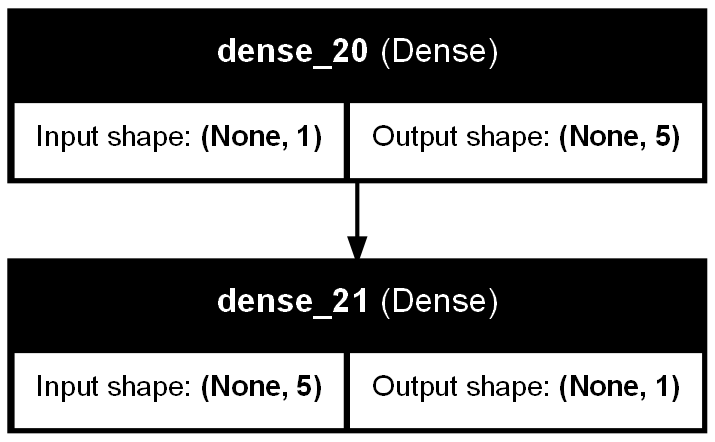

In [275]:
# Visualize the Model
plot_model(model, 
           to_file="model.png", 
           show_shapes=True, 
           show_layer_names=True, 
           dpi = 150) 

##### Parameter Estimates (Weights):

In [276]:
# showings the trainings weights of the trained model
for layer in model.layers:
    print(layer.name, layer.get_weights())

dense_20 [array([[-0.8503141,  1.3507469, -1.2871453,  1.1532671,  1.7345438]],
      dtype=float32), array([-0.01975713, -0.6427488 ,  0.4966211 , -0.36254355, -1.2154887 ],
      dtype=float32)]
dense_21 [array([[-0.6883755 ],
       [ 0.70385265],
       [-0.7467535 ],
       [ 0.47261158],
       [ 0.63374543]], dtype=float32), array([0.23518826], dtype=float32)]


##### GBP/USD Exchange Rate Predictions on Holdout set:

In [277]:
# Rescale predictions back to original values
y_test_rescaled = scaler.inverse_transform(y_test.values.reshape(-1, 1))
y_pred_rescaled = scaler.inverse_transform(predictions)


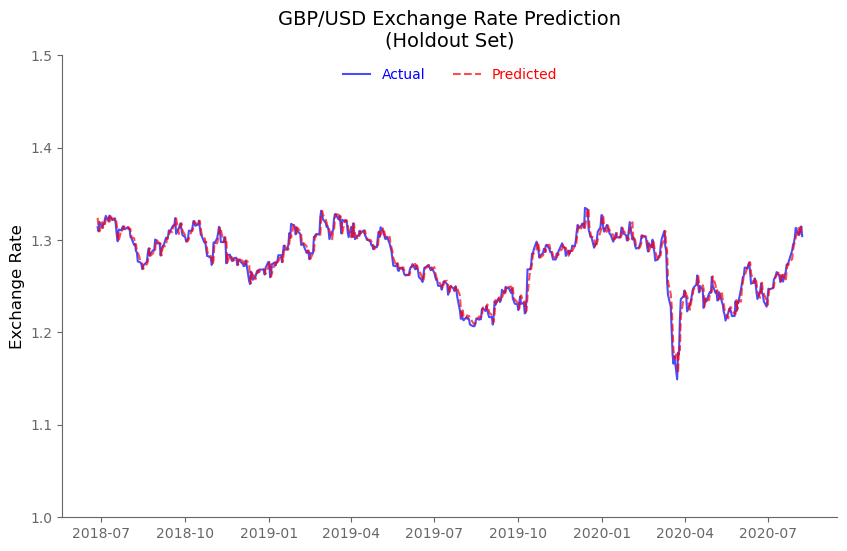

In [278]:
# create dataframe of testing/prediction results
df_test = y_test.to_frame()
df_test['y_test_rescaled'] = y_test_rescaled.flatten()
df_test['y_pred_rescaled'] = y_pred_rescaled.flatten()

# merge with df to get the date
df_comp  =  pd.merge(left = df,
            right         = df_test,
            left_index    = True,
            right_index   = True,
            how           = 'inner')

# create plots
plt.figure(figsize=(10, 6))

# actual plot
sns.lineplot(x     = df_comp['date'],
             y     = df_comp['y_test_rescaled'], 
             color = 'blue',
             alpha = 0.7,
             label = "Actual")

# prediction plot
sns.lineplot(x         = df_comp['date'],
             y         = df_comp['y_pred_rescaled'], 
             color     = 'red',
             alpha     = 0.7,
             label     ="Predicted", 
             linestyle ="dashed")

# y limits
plt.ylim(1,1.5)
# Plot results
plot_props(title   = 'GBP/USD Exchange Rate Prediction\n(Holdout Set)',
           y_label = 'Exchange Rate',
           lgn_loc = 'upper center',
           lgn_col = 2)

##### Conclusions:
- The ARNN Model Trained sucessfully as expected and stopped at epoch 94th as it returned the minimal validation loss.
- All the weights of the model are described at above.
- Initally, the Actual vs. Prediction Line Graph on Holdout set depicts a very good predictions of the model based on the most recent past value, as the prediction line aligns closely with the actual exchange rate.

#### 2.2. Explain the neural network with details and provide the performance analysis for the method. 

##### The ARNN Model Information:
- Type: Fully Connected Feed-forward
- Input: 1
- Output: 1
- Hidden Layer: 1 (with 5 perceptrons)
- Activation Function: Sigmoid (Hidden layer), Linear/Identify (Output layer)
- Optimise Algorithm: Adaptive Moment Estimation (ADAM) algorithm
- Max Epoch: 100, stop after 10 training cycles without lower validation loss
- Batch size: 4 

Samples size:
- Training: 68%
- Validation: 12%
- Holdout: 20%

##### Model Performance:

In [279]:
# Find the epoch with the lowest validation loss
best_epoch = history.history['val_loss'].index(min(history.history['val_loss']))

# Get the corresponding training and validation loss
best_training_loss = history.history['loss'][best_epoch]
best_valid_loss    = history.history['val_loss'][best_epoch]

print(f"Best epoch: {best_epoch + 1}")  # +1 because epochs start from 1
print(f"Training loss at best epoch: {best_training_loss:.6f}")
print(f"Validation loss at best epoch: {best_valid_loss:.6f}")

Best epoch: 94
Training loss at best epoch: 0.000245
Validation loss at best epoch: 0.000128


- Low loss values of `0.000128`: The model is learning well.
- Training loss > Validation loss: The model is not overfitted.
- Validation loss is at the minimal: The model is well-generalized to unseen data.

##### Errors:

In [280]:
# Compute Errors
rle = np.mean(np.abs(df_comp['y_test_rescaled'] - df_comp['y_pred_rescaled']) / np.abs(df_comp['y_test_rescaled'])) # relative errors
sse = np.sum((df_comp['y_test_rescaled'] - df_comp['y_pred_rescaled']) ** 2) # sum of squared errors
mse = np.mean((df_comp['y_test_rescaled'] - df_comp['y_pred_rescaled']) ** 2) # mean squared errors

# show error terms
print("Relative Error:", rle)
print("Sum of Squared Errors (SSE):", sse)
print("Mean Squared Errors (MSE):", mse)

Relative Error: 0.004248412236127131
Sum of Squared Errors (SSE): 0.030105232347541182
Mean Squared Errors (MSE): 5.4439841496457834e-05


- **Relative Error** (`0.00425`): This is a very low error, indicating that the model makes predictions with high accuracy relative to the actual values. This suggests that the model is well-fitted to the data and generalises well.
- **Sum of Squared Errors** (`0.0301`): SSE is the total squared difference between actual and predicted values. A lower SSE means fewer errors overall, which is a positive sign.

#### 2.3. Is the model you proposed a good model? How do you support the claim? Also provide the table of preferences for the input values and interpret it.

##### Actual vs. Predicted Values:

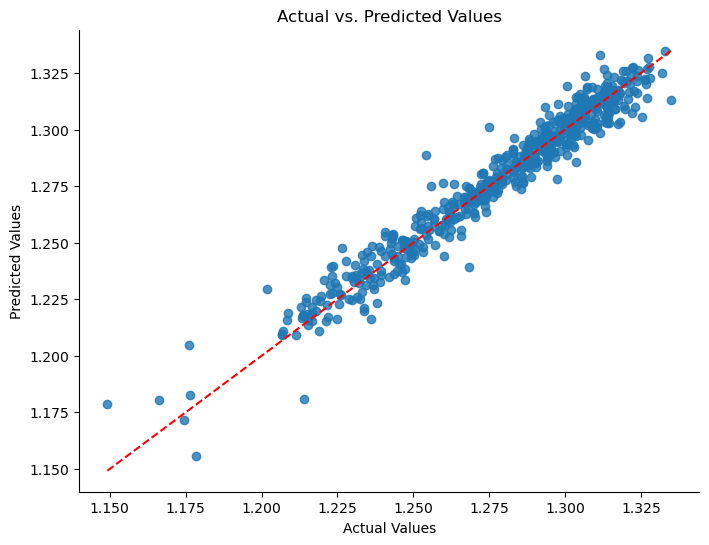

In [281]:
# Actual vs. Predicted Values plot
plt.figure(figsize=(8, 6))
plt.scatter(df_comp['y_test_rescaled'],
            df_comp['y_pred_rescaled'],
            alpha = 0.8)

# Create the perfect prediction line
x = np.linspace(df_comp['y_test_rescaled'].min(), df_comp['y_test_rescaled'].max(), 100)  # Create an array of 100 points from 0 to 10
y = x  
sns.lineplot(x = x, y = y, color='red', linestyle = 'dashed') 

plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
sns.despine()
plt.show()

##### Residual Plots:


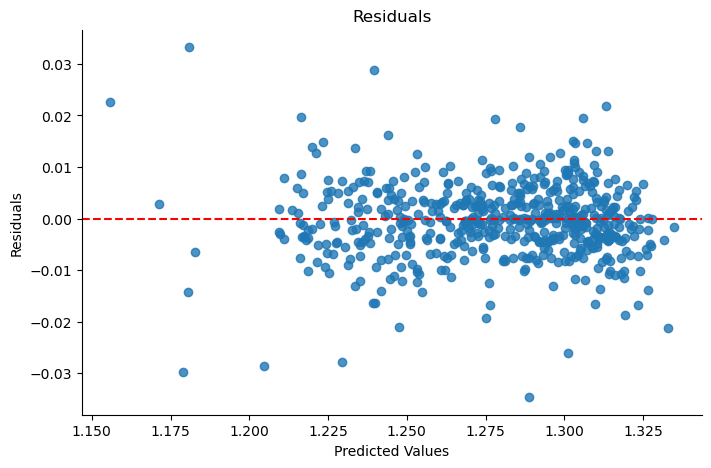

In [282]:
residuals = df_comp['y_test_rescaled'] - df_comp['y_pred_rescaled'] # residuals

# residual plot
plt.figure(figsize=(8, 5))
plt.scatter(df_comp['y_pred_rescaled'], residuals, alpha=0.8)
plt.axhline(0, color='red', linestyle='--')  # Zero error line
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals")
sns.despine()
plt.show()

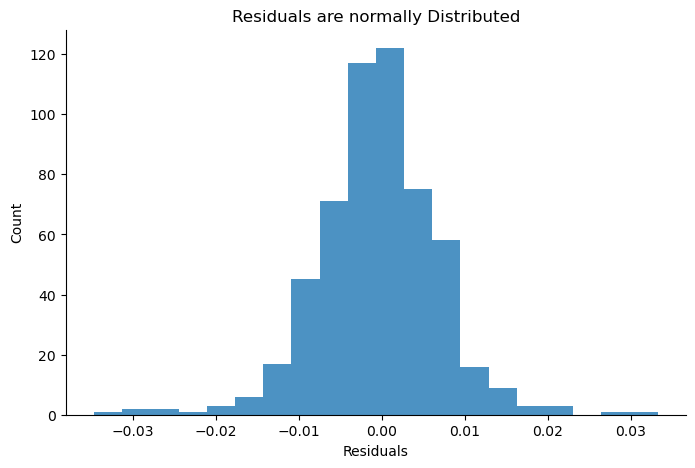

In [283]:
# residual histogram
plt.figure(figsize=(8, 5))
plt.hist(residuals, alpha=0.8, bins = 20)
plt.title('Residuals are normally Distributed')
plt.xlabel("Residuals")
plt.ylabel("Count")
sns.despine()
plt.show()

##### Feature Importances:

In [284]:
feature_names = X_train.columns.tolist()

# Compute feature importance using validation data
result = permutation_importance(model, X_train, y_train, scoring='neg_mean_squared_error')

feature_importance_df = pd.DataFrame({
    "Feature": feature_names,  # Replace with actual feature names
    "Importance": result.importances_mean
}).sort_values(by="Importance", ascending=False)

print(feature_importance_df)

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step
        Feature  Importance
0  lag_1_scaled    0.100347


##### Conclusions:

- Overall, the ARNN Model is a good model with low errors on holdout set with very few outliers around `+-0.03`, no sign of overfitting and genrealises the data well.
- The Prediction Residuals on holdout set is normally distributed around `0`. Predicted values mostly scatter around the perfect prediction line.
- The Importance value of `0.100347` suggests that `lag_1_scaled` has a moderate impact on the model's predictions. It is reasonable for the first lag to have moderate to high importance, especially in time series models where past values often influence future predictions.

#### 2.4. Forecast the Exchange GBP/USD Exchange Rate in `August 8 2020`: 

In [285]:
# the prediction date
pred_date = '2020-08-08'

# Assign Aug 8 datetime value to the last `lag_num` rows
df.loc[df.index[len(df) - lag_num], 'date'] = np.datetime64(pred_date)

# making predictions for August 8 2020

# the lag column names
lag_columns = [f'lag_{i}_scaled' for i in range(1, lag_num + 1)]

def predict(date):
    '''This function perform the forecast of 'DEXUSUK_scaled' using the trained ARNN Model 

    Arguments:
        date -- the index of the predicting date on the df
    '''
    # Slice the previous lag days
    prev_values = df['DEXUSUK_scaled'].loc[date - lag_num: date - 1].values.flatten()[::-1]

    # Assign the array to the lags corresponding to the current date
    df.loc[date, lag_columns] = prev_values

    # Convert to DataFrame with column names
    df_temp = pd.DataFrame(prev_values.reshape(1, -1), columns=lag_columns)

    # Set index as a specific date
    df_temp.index.values[0] = date

    # Predict based on the previous values
    prediction = model.predict(df_temp)  

    # Assign the prediction to the current 'DEXUSUK'
    df.at[date, 'DEXUSUK_scaled'] = prediction
    df.at[date, 'DEXUSUK']  = scaler.inverse_transform(prediction)
    
predict(df.index[df['date'] == pred_date][0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


##### The forecasted GBP/USD Exchange Rate on `8 Aug 2020`: `1.304182`

In [286]:
# show the Predicted value for 8 Aug 2020
df.tail(1)

,date,DEXUSUK,DEXUSUK_scaled,lag_1_scaled
2775,2020-08-08,1.304182,0.273192,0.2734
